# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score

# Extract train and test set

In [2]:
xtrain = pd.read_csv("valeo_xtrain.csv")
ytrain = pd.read_csv("valeo_ytrain.csv")
xtest = pd.read_csv("valeo_xtest.csv")

X_train_full = xtrain.to_numpy()
X_test_full = xtest.to_numpy()
y_train_full = ytrain.to_numpy().ravel()
y_train = np.copy(y_train_full)
X_train = np.copy(X_train_full)
X_test = np.copy(X_test_full)

X_full = np.concatenate((X_train, X_test), axis = 0)

index = ytrain[ytrain['Anomaly']==0].index.tolist()
index_anomally = ytrain[ytrain['Anomaly']==1].index.tolist()
X_normal = X_train[index]
y_normal = y_train[index]
X_anomally = X_train[index_anomally]
y_anomally = y_train[index_anomally]

# Standardisation

In [3]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler = preprocessing.StandardScaler().fit(X_full)
X_full = scaler.transform(X_full)

print(X_train.shape)
print(X_test.shape)
print(X_full.shape)

(27586, 27)
(27587, 27)
(55173, 27)


# Suppression des outliers des données normales

#### IQR

In [4]:
import numpy as np

IQR = []
for column in X_normal.T :
    Q1 = np.quantile(column,0.25)
    Q3 = np.quantile(column,0.75)
    IQR.append((Q1 - 1.5*(Q3 - Q1), Q3 + 1.5*(Q3 - Q1)))

idx = []
index = 0
for line in X_normal :
    k = 0
    for feature in line :
        if feature < IQR[k][0] or feature > IQR[k][1] :
            idx.append(index)
            break
        k+=1
    index +=1
print(len(idx)/len(X_normal))

X_train = np.concatenate((np.delete(X_normal, idx, 0), X_anomally), axis=0)
y_train = np.concatenate((np.delete(y_normal, idx, 0), y_anomally), axis=0)

0.17063919979176737


# Split train test set

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)

# Modèles

In [6]:
contamination = np.count_nonzero(y_train == 1) / len(y_train)
contamination

0.030134365352002434

### COPOD

In [20]:
from pyod.models.copod import COPOD

clf = COPOD(contamination = contamination)
clf.fit(X_train)

#0.6172656029613117

COPOD(contamination=0.02512143841078808)

In [35]:
from pyod.models.abod import ABOD

clf = ABOD(contamination = contamination, n_neighbors=20, method='fast')
clf.fit(X_train)
#0.56

ABOD(contamination=0.024968279862243974, method='fast', n_neighbors=20)

In [33]:
from pyod.models.auto_encoder import AutoEncoder

clf = AutoEncoder(hidden_neurons = [27, 5, 5, 27],epochs=100, batch_size=32, dropout_rate=0.2, l2_regularizer=0.1, validation_size=0.1
                  , preprocessing=True, verbose=1, random_state=None, contamination=contamination)
clf.fit(X_train)

# 0.5

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 27)                756       
_________________________________________________________________
dropout_12 (Dropout)         (None, 27)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 27)                756       
_________________________________________________________________
dropout_13 (Dropout)         (None, 27)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 27)                756       
_________________________________________________________________
dropout_14 (Dropout)         (None, 27)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                

621/621 [==============================] - 1s 2ms/step - loss: 0.9603 - val_loss: 7.5326
Epoch 62/100
621/621 [==============================] - 1s 2ms/step - loss: 0.9629 - val_loss: 7.5326
Epoch 63/100
621/621 [==============================] - 1s 2ms/step - loss: 0.9370 - val_loss: 7.5326
Epoch 64/100
621/621 [==============================] - 1s 2ms/step - loss: 0.9642 - val_loss: 7.5326
Epoch 65/100
621/621 [==============================] - 1s 2ms/step - loss: 0.9712 - val_loss: 7.5326
Epoch 66/100
621/621 [==============================] - 1s 2ms/step - loss: 0.9699 - val_loss: 7.5326
Epoch 67/100
621/621 [==============================] - 1s 2ms/step - loss: 0.9678 - val_loss: 7.5326
Epoch 68/100
621/621 [==============================] - 1s 2ms/step - loss: 0.9622 - val_loss: 7.5326
Epoch 69/100
621/621 [==============================] - 1s 2ms/step - loss: 0.9490 - val_loss: 7.5326
Epoch 70/100
621/621 [==============================] - 1s 2ms/step - loss: 0.9562 - val_loss: 

AutoEncoder(batch_size=32, contamination=0.024968279862243974,
      dropout_rate=0.2, epochs=100, hidden_activation='relu',
      hidden_neurons=[27, 5, 5, 27], l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000024809C8C0D8>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [ ]:
from pyod.models.cblof import CBLOF

from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=2,assign_labels="discretize")
clf = CBLOF(contamination = contamination, n_clusters=2, clustering_estimator =clustering)
clf.fit(X_train)

C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [10]:
from pyod.models.cof import COF

clf = COF(contamination=contamination, n_neighbors=2)
clf.fit(X_train)

# 0.6 mais seulement sur le train val

COF(contamination=0.025036818851251842, n_neighbors=None)

In [8]:
from pyod.models.feature_bagging import FeatureBagging

clf = FeatureBagging(base_estimator=None, n_estimators=10, contamination=contamination, max_features=1.0, bootstrap_features=False, 
           check_detector=True, check_estimator=False, n_jobs=1, random_state=None, combination='average',
           verbose=0, estimator_params=None)
clf.fit(X_train)

#0.5

FeatureBagging(base_estimator=None, bootstrap_features=False,
        check_detector=True, check_estimator=False, combination='average',
        contamination=0.024605764002175096, estimator_params={},
        max_features=1.0, n_estimators=10, n_jobs=1, random_state=None,
        verbose=0)

In [10]:
from pyod.models.hbos import HBOS

clf = HBOS(n_bins=10, alpha=0.1, tol=0.5, contamination=contamination)
clf.fit(X_train)

#0.65

HBOS(alpha=0.1, contamination=0.024605764002175096, n_bins=10, tol=0.5)

In [12]:
from pyod.models.iforest import IForest

clf = IForest(n_estimators=100, max_samples='auto', contamination=contamination, max_features=1.0, 
        bootstrap=False, n_jobs=1, behaviour='old', random_state=None, verbose=0)
clf.fit(X_train)

# 0.58

IForest(behaviour='old', bootstrap=False, contamination=0.024605764002175096,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [15]:
from pyod.models.knn import KNN

clf = KNN(contamination=contamination, n_neighbors=5, method='largest', radius=1.0, algorithm='auto',
          leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=1)
clf.fit(X_train)

#0.5263176850471933

KNN(algorithm='auto', contamination=0.024605764002175096, leaf_size=30,
  method='largest', metric='minkowski', metric_params=None, n_jobs=1,
  n_neighbors=5, p=2, radius=1.0)

In [19]:
from pyod.models.lmdd import LMDD

clf = LMDD(contamination=contamination, n_iter=2, dis_measure='aad', random_state=None)
clf.fit(X_train)



LMDD(contamination=0.024605764002175096, dis_measure='aad', n_iter=2,
   random_state=None)

In [21]:
from pyod.models.loda import LODA

clf = LODA(contamination=contamination, n_bins=10, n_random_cuts=100)
clf.fit(X_train)

# 0.4670479384003974

LODA(contamination=0.024605764002175096, n_bins=10, n_random_cuts=100)

In [23]:
from pyod.models.lof import LOF

clf = LOF(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, 
          metric_params=None, contamination=contamination, n_jobs=1)
clf.fit(X_train)

#compute pas 

LOF(algorithm='auto', contamination=0.024605764002175096, leaf_size=30,
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=20, p=2)

In [28]:
from pyod.models.loci import LOCI

clf = LOCI(contamination=contamination, alpha=0.5, k=1)
clf.fit(X_val)

#trop long

KeyboardInterrupt: 

In [29]:
from pyod.models.lscp import LSCP

clf = LSCP(detector_list, local_region_size=30, local_max_features=1.0, n_bins=10, 
           random_state=None, contamination=contamination)
clf.fit(X_train)



NameError: name 'detector_list' is not defined

In [30]:
from pyod.models.mcd import MCD

clf = MCD(contamination=contamination, store_precision=True, assume_centered=False, 
          support_fraction=None, random_state=None)
clf.fit(X_train)



C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-392.334369588882510 > -594.372448752129230). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-518.554869030623195 > -529.673038789515999). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: Runtime

C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-391.850454882065833 > -660.007933812554825). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-418.717778367884875 > -591.533022945305675). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-422.452495947406533 > -626.269123924268229). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning

C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-388.575052941109902 > -587.908598240965375). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-488.388297058675789 > -558.852063988521195). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-519.199932748234801 > -626.445893938180120). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning

C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-481.003299567082308 > -481.567448586984881). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-414.124109097352743 > -577.123314099052550). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-480.605562043495468 > -484.334548493263298). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning

C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-544.646417585618792 > -547.343148777607780). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-412.471200718832051 > -578.082109069945091). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-447.244659314004650 > -617.436869687311855). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning

C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-414.170640186036962 > -583.976664648330598). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-519.585477937339647 > -541.667873348684225). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-443.118726436617692 > -616.577312038791661). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning

C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-418.249297949468485 > -588.246312534535718). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-484.818420926114300 > -517.454404680391463). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-415.771636912046404 > -551.383030571252903). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning

C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-511.237305881037969 > -513.663168398209109). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-417.002692805735251 > -620.829698172316853). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-389.597260489247674 > -613.359807816825423). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning

MCD(assume_centered=False, contamination=0.024605764002175096,
  random_state=None, store_precision=True, support_fraction=None)

In [31]:
from pyod.models.mo_gaal import MO_GAAL

clf = MO_GAAL(k=10, stop_epochs=20, lr_d=0.01, lr_g=0.0001, decay=1e-06, momentum=0.9, contamination=contamination)
clf.fit(X_train)



Epoch 1 of 60

Testing for epoch 1 index 1:



Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:

Testing for epoch 1 index 25:

Testing for epoch 1 index 26:

Testing for epoch 1 index 27:

Testing for epoch 1 index 28:

Testing for epoch 1 index 29:

Testing for epoch 1 index 30:

Testing for epoch 1 index 31:

Testing for epoch 1 index 32:


KeyboardInterrupt: 

In [22]:
# One class svm !

from pyod.models.ocsvm import OCSVM

clf = OCSVM(kernel='poly', degree=5, gamma='scale', coef0=0.0, tol=0.001, nu=0.99, 
            shrinking=True, cache_size=200, verbose=False, max_iter=- 1, contamination=contamination)
clf.fit(X_train)

#0.6692921013412817

OCSVM(cache_size=200, coef0=0.0, contamination=0.001, degree=5, gamma='scale',
   kernel='rbf', max_iter=-1, nu=0.99, shrinking=True, tol=0.001,
   verbose=False)

In [16]:
np.concatenate((X_train[index], Xtest), axis = 0)

IndexError: index 22344 is out of bounds for axis 0 with size 22344

In [10]:
from pyod.models.rod import ROD

clf = ROD(contamination=contamination, parallel_execution=False)
clf.fit(X_val)



KeyboardInterrupt: 

In [8]:
from pyod.models.sod import SOD

clf = SOD(contamination=contamination, n_neighbors=20, ref_set=10, alpha=0.8)
clf.fit(X_val)

#0.57

SOD(alpha=None, contamination=0.025196920873612604, n_neighbors=None,
  ref_set=None)

In [11]:
from pyod.models.so_gaal import SO_GAAL

clf = SO_GAAL(stop_epochs=20, lr_d=0.01, lr_g=0.0001, decay=1e-06, momentum=0.9, contamination=contamination)
clf.fit(X_train)

#0.5870339799147063

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:

Testing for epoch 1 index 25:

Testing for epoch 1 index 26:

Testing for epoch 1 index 27:

Testing for epoch 1 index 28:

Testing for epoch 1 index 29:

Testing for epoch 1 index 30:

Testing for epoch 1 index 31:

Testing for epoch 1 index 32:

Te


Testing for epoch 7 index 2:

Testing for epoch 7 index 3:

Testing for epoch 7 index 4:

Testing for epoch 7 index 5:

Testing for epoch 7 index 6:

Testing for epoch 7 index 7:

Testing for epoch 7 index 8:

Testing for epoch 7 index 9:

Testing for epoch 7 index 10:

Testing for epoch 7 index 11:

Testing for epoch 7 index 12:

Testing for epoch 7 index 13:

Testing for epoch 7 index 14:

Testing for epoch 7 index 15:

Testing for epoch 7 index 16:

Testing for epoch 7 index 17:

Testing for epoch 7 index 18:

Testing for epoch 7 index 19:

Testing for epoch 7 index 20:

Testing for epoch 7 index 21:

Testing for epoch 7 index 22:

Testing for epoch 7 index 23:

Testing for epoch 7 index 24:

Testing for epoch 7 index 25:

Testing for epoch 7 index 26:

Testing for epoch 7 index 27:

Testing for epoch 7 index 28:

Testing for epoch 7 index 29:

Testing for epoch 7 index 30:

Testing for epoch 7 index 31:

Testing for epoch 7 index 32:

Testing for epoch 7 index 33:

Testing for epo


Testing for epoch 12 index 44:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:

Testing for epoch 13 index 3:

Testing for epoch 13 index 4:

Testing for epoch 13 index 5:

Testing for epoch 13 index 6:

Testing for epoch 13 index 7:

Testing for epoch 13 index 8:

Testing for epoch 13 index 9:

Testing for epoch 13 index 10:

Testing for epoch 13 index 11:

Testing for epoch 13 index 12:

Testing for epoch 13 index 13:

Testing for epoch 13 index 14:

Testing for epoch 13 index 15:

Testing for epoch 13 index 16:

Testing for epoch 13 index 17:

Testing for epoch 13 index 18:

Testing for epoch 13 index 19:

Testing for epoch 13 index 20:

Testing for epoch 13 index 21:

Testing for epoch 13 index 22:

Testing for epoch 13 index 23:

Testing for epoch 13 index 24:

Testing for epoch 13 index 25:

Testing for epoch 13 index 26:

Testing for epoch 13 index 27:

Testing for epoch 13 index 28:

Testing for epoch 13 index 29:

Testing for epoch 13 index 30:

T


Testing for epoch 18 index 37:

Testing for epoch 18 index 38:

Testing for epoch 18 index 39:

Testing for epoch 18 index 40:

Testing for epoch 18 index 41:

Testing for epoch 18 index 42:

Testing for epoch 18 index 43:

Testing for epoch 18 index 44:
Epoch 19 of 60

Testing for epoch 19 index 1:

Testing for epoch 19 index 2:

Testing for epoch 19 index 3:

Testing for epoch 19 index 4:

Testing for epoch 19 index 5:

Testing for epoch 19 index 6:

Testing for epoch 19 index 7:

Testing for epoch 19 index 8:

Testing for epoch 19 index 9:

Testing for epoch 19 index 10:

Testing for epoch 19 index 11:

Testing for epoch 19 index 12:

Testing for epoch 19 index 13:

Testing for epoch 19 index 14:

Testing for epoch 19 index 15:

Testing for epoch 19 index 16:

Testing for epoch 19 index 17:

Testing for epoch 19 index 18:

Testing for epoch 19 index 19:

Testing for epoch 19 index 20:

Testing for epoch 19 index 21:

Testing for epoch 19 index 22:

Testing for epoch 19 index 23:

T

16/16 [==============================] - 0s 1ms/step - loss: 5.8535

Testing for epoch 24 index 31:
16/16 [==============================] - 0s 1ms/step - loss: 5.8543

Testing for epoch 24 index 32:
16/16 [==============================] - 0s 1ms/step - loss: 5.8580

Testing for epoch 24 index 33:
16/16 [==============================] - 0s 1ms/step - loss: 5.8514

Testing for epoch 24 index 34:
16/16 [==============================] - 0s 1ms/step - loss: 5.8754

Testing for epoch 24 index 35:
16/16 [==============================] - 0s 1ms/step - loss: 5.8720

Testing for epoch 24 index 36:
16/16 [==============================] - 0s 1ms/step - loss: 5.8806

Testing for epoch 24 index 37:
16/16 [==============================] - 0s 1ms/step - loss: 5.8862

Testing for epoch 24 index 38:
16/16 [==============================] - 0s 1ms/step - loss: 5.8895

Testing for epoch 24 index 39:
16/16 [==============================] - 0s 1ms/step - loss: 5.8880

Testing for epoch 24 index 40:


16/16 [==============================] - 0s 1ms/step - loss: 6.3538

Testing for epoch 28 index 17:
16/16 [==============================] - 0s 1ms/step - loss: 6.3577

Testing for epoch 28 index 18:
16/16 [==============================] - 0s 1ms/step - loss: 6.3481

Testing for epoch 28 index 19:
16/16 [==============================] - 0s 1ms/step - loss: 6.3665

Testing for epoch 28 index 20:
16/16 [==============================] - 0s 1ms/step - loss: 6.3751

Testing for epoch 28 index 21:
16/16 [==============================] - 0s 1ms/step - loss: 6.3631

Testing for epoch 28 index 22:
16/16 [==============================] - 0s 1ms/step - loss: 6.3654

Testing for epoch 28 index 23:
16/16 [==============================] - 0s 1ms/step - loss: 6.3737

Testing for epoch 28 index 24:
16/16 [==============================] - 0s 1ms/step - loss: 6.3713

Testing for epoch 28 index 25:
16/16 [==============================] - 0s 1ms/step - loss: 6.3668

Testing for epoch 28 index 26:


16/16 [==============================] - 0s 1ms/step - loss: 6.6767

Testing for epoch 32 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 6.6770

Testing for epoch 32 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 6.6779

Testing for epoch 32 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 6.6871

Testing for epoch 32 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 6.6789

Testing for epoch 32 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 6.6691

Testing for epoch 32 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 6.6812

Testing for epoch 32 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 6.6817

Testing for epoch 32 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 6.6892

Testing for epoch 32 index 11:
16/16 [==============================] - 0s 1ms/step - loss: 6.6762

Testing for epoch 32 index 12:
16/16 [


Testing for epoch 33 index 40:
16/16 [==============================] - 0s 997us/step - loss: 6.7890

Testing for epoch 33 index 41:
16/16 [==============================] - 0s 997us/step - loss: 6.8129

Testing for epoch 33 index 42:
16/16 [==============================] - 0s 1ms/step - loss: 6.7904

Testing for epoch 33 index 43:
16/16 [==============================] - 0s 1ms/step - loss: 6.8239

Testing for epoch 33 index 44:
16/16 [==============================] - 0s 1ms/step - loss: 6.7912
Epoch 34 of 60

Testing for epoch 34 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 6.8147

Testing for epoch 34 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 6.7941

Testing for epoch 34 index 3:
16/16 [==============================] - 0s 997us/step - loss: 6.8201

Testing for epoch 34 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 6.8089

Testing for epoch 34 index 5:
16/16 [==============================] - 0s 995us/st

16/16 [==============================] - 0s 1ms/step - loss: 6.9861

Testing for epoch 37 index 27:
16/16 [==============================] - 0s 997us/step - loss: 6.9901

Testing for epoch 37 index 28:
16/16 [==============================] - 0s 1ms/step - loss: 6.9986

Testing for epoch 37 index 29:
16/16 [==============================] - 0s 1ms/step - loss: 6.9967

Testing for epoch 37 index 30:
16/16 [==============================] - 0s 998us/step - loss: 7.0223

Testing for epoch 37 index 31:
16/16 [==============================] - 0s 1ms/step - loss: 6.9814

Testing for epoch 37 index 32:
16/16 [==============================] - 0s 1ms/step - loss: 7.0020

Testing for epoch 37 index 33:
16/16 [==============================] - 0s 1ms/step - loss: 7.0078

Testing for epoch 37 index 34:
16/16 [==============================] - 0s 1ms/step - loss: 6.9962

Testing for epoch 37 index 35:
16/16 [==============================] - 0s 1ms/step - loss: 7.0142

Testing for epoch 37 index 

16/16 [==============================] - 0s 1ms/step - loss: 7.1698

Testing for epoch 41 index 13:
16/16 [==============================] - 0s 1ms/step - loss: 7.1912

Testing for epoch 41 index 14:
16/16 [==============================] - 0s 1ms/step - loss: 7.1664

Testing for epoch 41 index 15:
16/16 [==============================] - 0s 1ms/step - loss: 7.1654

Testing for epoch 41 index 16:
16/16 [==============================] - 0s 3ms/step - loss: 7.1915

Testing for epoch 41 index 17:
16/16 [==============================] - 0s 1ms/step - loss: 7.1676

Testing for epoch 41 index 18:
16/16 [==============================] - 0s 1ms/step - loss: 7.1583

Testing for epoch 41 index 19:
16/16 [==============================] - 0s 1ms/step - loss: 7.1492

Testing for epoch 41 index 20:
16/16 [==============================] - 0s 1ms/step - loss: 7.1541

Testing for epoch 41 index 21:
16/16 [==============================] - 0s 997us/step - loss: 7.1689

Testing for epoch 41 index 22


Testing for epoch 44 index 43:
16/16 [==============================] - 0s 1ms/step - loss: 7.3177

Testing for epoch 44 index 44:
16/16 [==============================] - 0s 1ms/step - loss: 7.3117
Epoch 45 of 60

Testing for epoch 45 index 1:
16/16 [==============================] - 0s 931us/step - loss: 7.2834

Testing for epoch 45 index 2:
16/16 [==============================] - 0s 997us/step - loss: 7.3220

Testing for epoch 45 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 7.3181

Testing for epoch 45 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 7.3149

Testing for epoch 45 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 7.2916

Testing for epoch 45 index 6:
16/16 [==============================] - 0s 1ms/step - loss: 7.3184

Testing for epoch 45 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 7.2846

Testing for epoch 45 index 8:
16/16 [==============================] - 0s 1ms/step - lo

16/16 [==============================] - 0s 1ms/step - loss: 7.4389

Testing for epoch 48 index 30:
16/16 [==============================] - 0s 1ms/step - loss: 7.4470

Testing for epoch 48 index 31:
16/16 [==============================] - 0s 1ms/step - loss: 7.4182

Testing for epoch 48 index 32:
16/16 [==============================] - 0s 1ms/step - loss: 7.4365

Testing for epoch 48 index 33:
16/16 [==============================] - 0s 997us/step - loss: 7.4541

Testing for epoch 48 index 34:
16/16 [==============================] - 0s 1ms/step - loss: 7.4167

Testing for epoch 48 index 35:
16/16 [==============================] - 0s 1ms/step - loss: 7.4562

Testing for epoch 48 index 36:
16/16 [==============================] - 0s 1ms/step - loss: 7.4426

Testing for epoch 48 index 37:
16/16 [==============================] - 0s 1ms/step - loss: 7.4547

Testing for epoch 48 index 38:
16/16 [==============================] - 0s 1ms/step - loss: 7.4304

Testing for epoch 48 index 39

16/16 [==============================] - 0s 1ms/step - loss: 7.5414

Testing for epoch 52 index 16:
16/16 [==============================] - 0s 2ms/step - loss: 7.5477

Testing for epoch 52 index 17:
16/16 [==============================] - 0s 997us/step - loss: 7.5331

Testing for epoch 52 index 18:
16/16 [==============================] - 0s 1ms/step - loss: 7.5616

Testing for epoch 52 index 19:
16/16 [==============================] - 0s 2ms/step - loss: 7.5423

Testing for epoch 52 index 20:
16/16 [==============================] - 0s 2ms/step - loss: 7.5295

Testing for epoch 52 index 21:
16/16 [==============================] - 0s 1ms/step - loss: 7.5421

Testing for epoch 52 index 22:
16/16 [==============================] - 0s 1ms/step - loss: 7.5496

Testing for epoch 52 index 23:
16/16 [==============================] - 0s 2ms/step - loss: 7.5670

Testing for epoch 52 index 24:
16/16 [==============================] - 0s 1ms/step - loss: 7.5341

Testing for epoch 52 index 25

16/16 [==============================] - 0s 1ms/step - loss: 7.6250

Testing for epoch 56 index 2:
16/16 [==============================] - 0s 997us/step - loss: 7.6242

Testing for epoch 56 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 7.6516

Testing for epoch 56 index 4:
16/16 [==============================] - 0s 1ms/step - loss: 7.6307

Testing for epoch 56 index 5:
16/16 [==============================] - 0s 1ms/step - loss: 7.6203

Testing for epoch 56 index 6:
16/16 [==============================] - 0s 997us/step - loss: 7.6462

Testing for epoch 56 index 7:
16/16 [==============================] - 0s 1ms/step - loss: 7.6534

Testing for epoch 56 index 8:
16/16 [==============================] - 0s 1ms/step - loss: 7.6670

Testing for epoch 56 index 9:
16/16 [==============================] - 0s 1ms/step - loss: 7.6419

Testing for epoch 56 index 10:
16/16 [==============================] - 0s 1ms/step - loss: 7.6362

Testing for epoch 56 index 11:
16/1

16/16 [==============================] - 0s 1ms/step - loss: 7.7010

Testing for epoch 59 index 32:
16/16 [==============================] - 0s 1ms/step - loss: 7.7326

Testing for epoch 59 index 33:
16/16 [==============================] - 0s 1ms/step - loss: 7.7210

Testing for epoch 59 index 34:
16/16 [==============================] - 0s 1ms/step - loss: 7.7256

Testing for epoch 59 index 35:
16/16 [==============================] - 0s 931us/step - loss: 7.7299

Testing for epoch 59 index 36:
16/16 [==============================] - 0s 1ms/step - loss: 7.7454

Testing for epoch 59 index 37:
16/16 [==============================] - 0s 1ms/step - loss: 7.7073

Testing for epoch 59 index 38:
16/16 [==============================] - 0s 1ms/step - loss: 7.7108

Testing for epoch 59 index 39:
16/16 [==============================] - 0s 1ms/step - loss: 7.6892

Testing for epoch 59 index 40:
16/16 [==============================] - 0s 1ms/step - loss: 7.7198

Testing for epoch 59 index 41

SO_GAAL(contamination=0.025196920873612604, decay=1e-06, lr_d=0.01,
    lr_g=0.0001, momentum=0.9, stop_epochs=20)

In [13]:
from pyod.models.sos import SOS

clf = SOS(contamination=contamination, perplexity=4.5, metric='euclidean', eps=1e-05)
clf.fit(X_train)



SOS(contamination=0.025196920873612604, eps=1e-05, metric='euclidean',
  perplexity=4.5)

In [ ]:
from pyod.models.vae import

clf = VAE(encoder_neurons=None, decoder_neurons=None, latent_dim=2, hidden_activation='relu', 
          output_activation='sigmoid', loss=<function mean_squared_error>, optimizer='adam', 
          epochs=100, batch_size=32, dropout_rate=0.2, l2_regularizer=0.1, validation_size=0.1, 
          preprocessing=True, verbose=1, random_state=None, contamination=contamination, gamma=1.0, capacity=0.0)
clf.fit(X_train)



In [7]:
from pyod.models.xgbod import XGBOD
from pyod.models.ocsvm import OCSVM
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD
from pyod.models.abod import ABOD

clf1 = OCSVM(kernel='poly', degree=5, gamma='scale', coef0=0.0, tol=0.001, nu=0.8, 
            shrinking=True, cache_size=200, verbose=False, max_iter=- 1, contamination=contamination)


clf2 = IForest(n_estimators=50, max_samples='auto', contamination=contamination, max_features=1.0, 
        bootstrap=False, n_jobs=1, behaviour='old', random_state=None, verbose=0)


clf3 = HBOS(n_bins=5, alpha=0.1, tol=0.5, contamination=contamination)


clf4 = COPOD(contamination = contamination)


# clf5 = ABOD(contamination = contamination, n_neighbors=10, method='fast')


estimator_list = [clf1, clf2, clf3, clf4]
clf = XGBOD(estimator_list=estimator_list, standardization_flag_list=None, max_depth=3, learning_rate=0.1, 
            n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, 
            nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
            colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.65, 
            missing=None)
clf.fit(X_train, y_train)



C:\Users\antoi\Anaconda3\lib\site-packages\pyod\models\base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")
C:\Users\antoi\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBOD(base_score=0.65, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1,
   estimator_list=[OCSVM(cache_size=200, coef0=0.0, contamination=0.030134365352002434, degree=5,
   gamma='scale', kernel='poly', max_iter=-1, nu=0.8, shrinking=True,
   tol=0.001, verbose=False), IForest(behaviour='old', bootstrap=False, contamination=0.030134365352002434,
    max_features=1.0, max_samples='auto', n_estimators=50, n_jobs=1,
    random_state=None, verbose=0), HBOS(alpha=0.1, contamination=0.030134365352002434, n_bins=5, tol=0.5), COPOD(contamination=0.030134365352002434)],
   gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
   min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
   nthread=None, objective='binary:logistic', random_state=0, reg_alpha=0,
   reg_lambda=1, scale_pos_weight=1, silent=True,
   standardization_flag_list=[True, True, True, True], subsample=1)

In [7]:
from pyod.models.combination import aom

clf = aom( n_buckets=5, method='static', bootstrap_estimators=False)
clf.fit(X_train)

TypeError: aom() missing 1 required positional argument: 'scores'

# Confusion matrix

<AxesSubplot:>

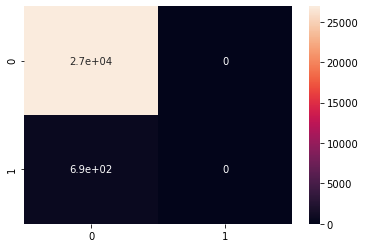

In [31]:
cm = confusion_matrix(y_train, clf.predict(X_train))
sns.heatmap(cm, annot=True)

# ROC

In [13]:
decif = clf.decision_function(X_val)
roc_auc_score(y_val, decif)

0.8379942782373424

In [16]:
decif = clf.decision_function(X_val)
roc_auc_score(y_val, decif)

0.8189806583696999

In [14]:
decif = clf.decision_function(X_train)
roc_auc_score(y_train, decif)

0.8744656869326419

In [8]:
decif = clf.decision_function(X_test)
np.savetxt('ytest_challenge_student.csv', decif, fmt = '%1.6f', delimiter=',')